#  PROJECT DEFAULT PREDICTION

## Course: Seminar in Master of Science in Quantitative Finance and Data Science
## Author: Minh Thu Nguyen
## Date: 20 February 2026 



 

# Table of Contents

## 1 Exploratory Data Analysis (EDA) 

## 2 Empirical Evaluation 
 
### 2.1 Baseline Results

### 2.2 Optimized Models Result 

### 2.3 Robustness Checks 

## 3 Interpretation of Results 

In [31]:
!pip install shap

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

import shap
import matplotlib.pyplot as plt

## 1 Exploratory Data Analysis (EDA)

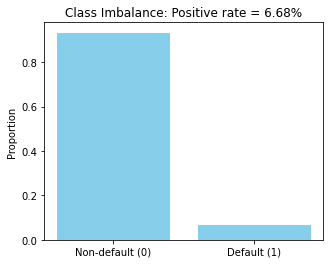

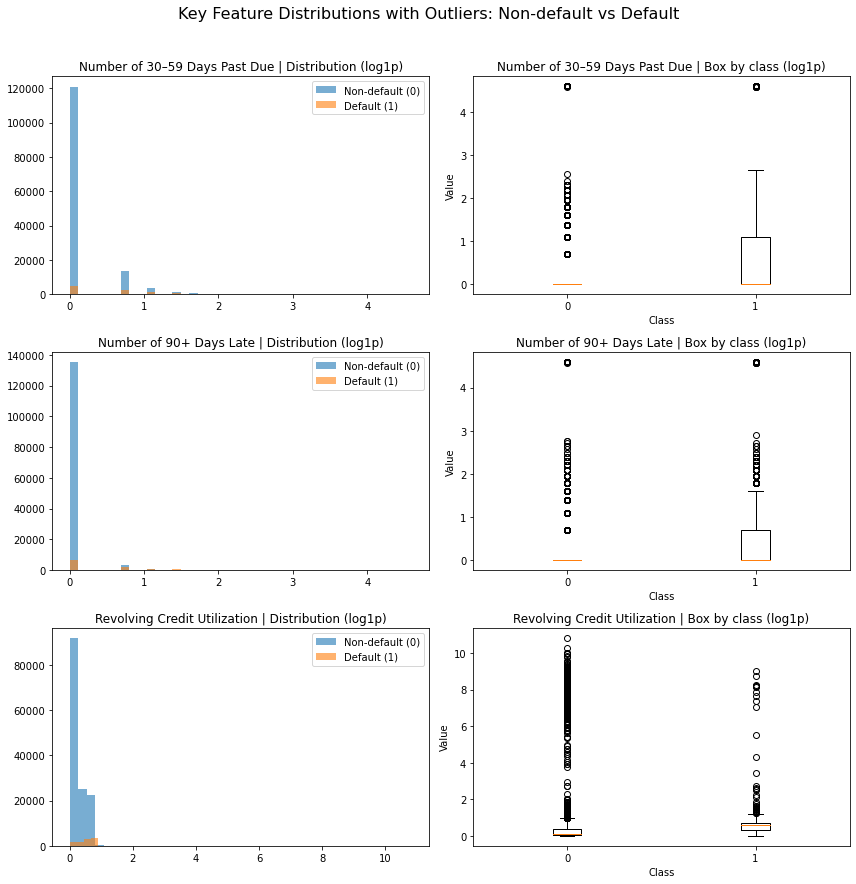

In [32]:

# Load data
DATA_PATH = "cs-training.csv"
TARGET = "SeriousDlqin2yrs"

df = pd.read_csv(DATA_PATH)
for col in ["Unnamed: 0", "ID", "Id", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

# Show class imbalance
pos_rate = float(y.mean())
plt.figure(figsize=(5,4))
plt.bar(["Non-default (0)", "Default (1)"], [1-pos_rate, pos_rate], color=["skyblue","skyblue"])
plt.ylabel("Proportion")
plt.title(f"Class Imbalance: Positive rate = {pos_rate*100:.2f}%")
plt.show()

# Function for safe log transform
def safe_log_series(s):
    s = s.dropna()
    if len(s) == 0:
        return s, False
    if s.min() >= 0:
        return np.log1p(s), True
    return s, False


show_feats = {
    "NumberOfTime30-59DaysPastDueNotWorse": "Number of 30–59 Days Past Due",
    "NumberOfTimes90DaysLate": "Number of 90+ Days Late",
    "RevolvingUtilizationOfUnsecuredLines": "Revolving Credit Utilization"
}

fig = plt.figure(figsize=(12, 12))
grid_rows = len(show_feats)

for i, (feat, feat_name) in enumerate(show_feats.items(), start=1):
    s0 = df.loc[df[TARGET] == 0, feat]
    s1 = df.loc[df[TARGET] == 1, feat]

    s0x, used_log0 = safe_log_series(s0)
    s1x, used_log1 = safe_log_series(s1)
    used_log = used_log0 and used_log1

    # Histogram
    ax1 = plt.subplot(grid_rows, 2, (i - 1) * 2 + 1)
    ax1.hist(s0x, bins=40, alpha=0.6, label="Non-default (0)")
    ax1.hist(s1x, bins=40, alpha=0.6, label="Default (1)")
    ax1.set_title(f"{feat_name} | Distribution{' (log1p)' if used_log else ''}")
    ax1.legend()

    # Boxplot showing outliers
    ax2 = plt.subplot(grid_rows, 2, (i - 1) * 2 + 2)
    ax2.boxplot([s0x.values, s1x.values], labels=["0", "1"])  # showfliers=True
    ax2.set_title(f"{feat_name} | Box by class{' (log1p)' if used_log else ''}")
    ax2.set_xlabel("Class")
    ax2.set_ylabel("Value")

plt.suptitle("Key Feature Distributions with Outliers: Non-default vs Default", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()



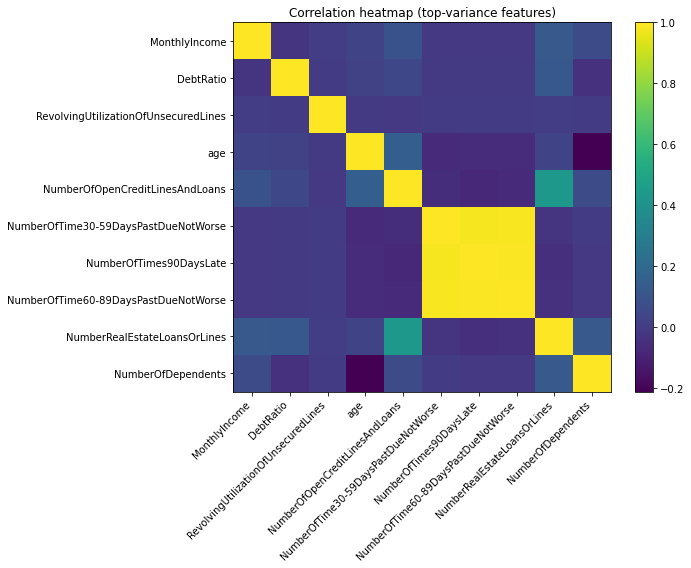

In [33]:
# Correlation heatmap (top numeric features only)

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]

var_rank = X[num_cols].var(numeric_only=True).sort_values(ascending=False)
heat_cols = list(var_rank.head(min(12, len(var_rank))).index)

corr = X[heat_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(heat_cols)), heat_cols, rotation=45, ha="right")
plt.yticks(range(len(heat_cols)), heat_cols)
plt.title("Correlation heatmap (top-variance features)")
plt.colorbar()
plt.tight_layout()
plt.show()

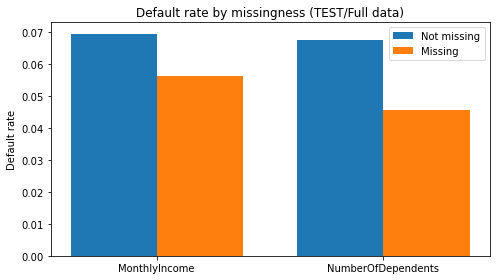

In [34]:
TARGET = "SeriousDlqin2yrs"
cols = ["MonthlyIncome", "NumberOfDependents"]

rows = []
for c in cols:
    miss = df[c].isna()
    rate_miss = df.loc[miss, TARGET].mean()
    rate_nomiss = df.loc[~miss, TARGET].mean()
    rows.append([c, rate_nomiss, rate_miss])

tmp = pd.DataFrame(rows, columns=["feature", "default_rate_not_missing", "default_rate_missing"])

x = np.arange(len(tmp))
w = 0.38

plt.figure(figsize=(7, 4))
plt.bar(x - w/2, tmp["default_rate_not_missing"], width=w, label="Not missing")
plt.bar(x + w/2, tmp["default_rate_missing"], width=w, label="Missing")
plt.xticks(x, tmp["feature"], rotation=0)
plt.ylabel("Default rate")
plt.title("Default rate by missingness (TEST/Full data)")
plt.legend()
plt.tight_layout()
plt.show()


# 2 Empirical Evaluation

## 2.1 Baseline Results (RF and MLP)

Positive rate train=0.0668 | val=0.0668 | test=0.0668

================ RF Baseline ================
TEST ROC-AUC: 0.8623
TEST PR-AUC : 0.4020

Confusion matrix (thr=0.5):
[[24614  3381]
 [  678  1327]]

Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9732    0.8792    0.9238     27995
           1     0.2819    0.6618    0.3954      2005

    accuracy                         0.8647     30000
   macro avg     0.6275    0.7705    0.6596     30000
weighted avg     0.9270    0.8647    0.8885     30000


================ MLP Baseline ================
TEST ROC-AUC: 0.8337
TEST PR-AUC : 0.3700

Confusion matrix (thr=0.5):
[[27693   302]
 [ 1612   393]]

Classification report (thr=0.5):
              precision    recall  f1-score   support

           0     0.9450    0.9892    0.9666     27995
           1     0.5655    0.1960    0.2911      2005

    accuracy                         0.9362     30000
   macro avg     0.7552    0.5926 

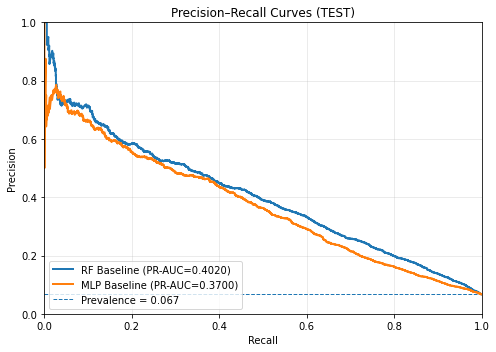

In [35]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve
)


df = pd.read_csv(DATA_PATH)

for col in ["Unnamed: 0", "ID", "Id", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

assert TARGET in df.columns, f"Target '{TARGET}' not found."

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])


X = X.apply(pd.to_numeric, errors="coerce")


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Positive rate train={y_train.mean():.4f} | val={y_val.mean():.4f} | test={y_test.mean():.4f}")

numeric_cols = X_train.columns.tolist()


#  RF baseline pipeline: median impute

rf_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_cols),
    ],
    remainder="drop"
)

rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    max_features="sqrt",
    min_samples_leaf=20,
    bootstrap=True,
    class_weight="balanced_subsample"
)

rf_baseline = Pipeline(steps=[
    ("prep", rf_preprocess),
    ("rf", rf)
])

rf_baseline.fit(X_train, y_train)


#  MLP baseline pipeline: median impute + scaler

mlp_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=256,
    max_iter=200,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    random_state=42
)

mlp_baseline = Pipeline(steps=[
    ("prep", mlp_preprocess),
    ("mlp", mlp)
])

mlp_baseline.fit(X_train, y_train)


# valuate on TEST: ROC-AUC / PR-AUC 

THR = 0.5

def eval_model(name, model, X_test, y_test, thr=0.5):
    p = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, p)
    ap = average_precision_score(y_test, p)
    y_pred = (p >= thr).astype(int)

    print(f"\n================ {name} ================")
    print(f"TEST ROC-AUC: {auc:.4f}")
    print(f"TEST PR-AUC : {ap:.4f}")
    print(f"\nConfusion matrix (thr={thr}):")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification report (thr={thr}):")
    print(classification_report(y_test, y_pred, digits=4))
    return ap

ap_rf = eval_model("RF Baseline", rf_baseline, X_test, y_test, thr=THR)
ap_mlp = eval_model("MLP Baseline", mlp_baseline, X_test, y_test, thr=THR)

#  Plot PR curves 

plt.figure(figsize=(7, 5))

# prevalence baseline
pos_rate = y_test.mean()
plt.hlines(pos_rate, 0, 1, linestyles="--", linewidth=1, label=f"Prevalence = {pos_rate:.3f}")

for name, model in [("RF Baseline", rf_baseline), ("MLP Baseline", mlp_baseline)]:
    p = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, p)
    ap = average_precision_score(y_test, p)
    plt.plot(recall, precision, linewidth=2, label=f"{name} (PR-AUC={ap:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (TEST)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


## 2.2 Optimized Models Results

### 1. Random Forest 



Positive rate train=0.0668 | val=0.0668 | test=0.0668
Shapes: train=(90000, 10), val=(30000, 10), test=(30000, 10)
Fitting 2 folds for each of 12 candidates, totalling 24 fits

Best CV PR-AUC (AvgPrecision): 0.38269377258677395
Best params: {'rf__n_estimators': 400, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 40, 'rf__max_features': 0.5, 'rf__max_depth': 14}

[RF Optimized | 60/20/20] TEST ROC-AUC: 0.8636
[RF Optimized | 60/20/20] TEST PR-AUC : 0.3999

=== RF Optimized - TEST @ fixed threshold (0.5) | threshold=0.50 ===
Confusion matrix:
[[23564  4431]
 [  563  1442]]

Classification report:
              precision    recall  f1-score   support

           0     0.9767    0.8417    0.9042     27995
           1     0.2455    0.7192    0.3661      2005

    accuracy                         0.8335     30000
   macro avg     0.6111    0.7805    0.6351     30000
weighted avg     0.9278    0.8335    0.8682     30000



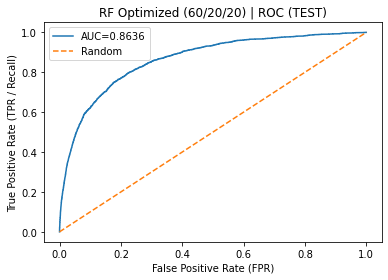

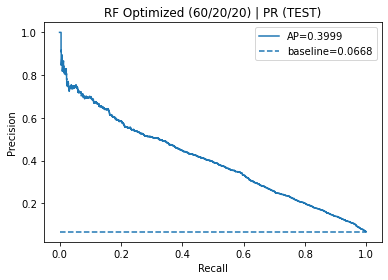

In [36]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin


class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high
        self.lo_ = None
        self.hi_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.lo_ = np.nanquantile(X, self.low, axis=0)
        self.hi_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.lo_, self.hi_)


class SafeLog1p(BaseEstimator, TransformerMixin):
    def __init__(self, eps=0.0):
        self.eps = eps
        self.can_log_ = None

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.can_log_ = np.nanmin(X, axis=0) >= 0
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X_out = X.copy()
        if self.can_log_ is None:
            return X_out
        cols = np.where(self.can_log_)[0]
        if len(cols) > 0:
            X_out[:, cols] = np.log1p(np.maximum(X_out[:, cols], 0) + self.eps)
        return X_out



# Fixed threshold evaluation

def eval_at_threshold(y_true, p, thr, title):
    y_pred = (p >= thr).astype(int)
    print(f"\n=== {title} | threshold={thr:.2f} ===")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))


def plot_roc_pr(model, X_test, y_test, title_prefix="Model"):
    p = model.predict_proba(X_test)[:, 1]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, p)
    auc = roc_auc_score(y_test, p)
    plt.figure(figsize=(5.5, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR / Recall)")
    plt.title(f"{title_prefix} | ROC (TEST)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_test, p)
    ap = average_precision_score(y_test, p)
    baseline_rate = float(np.mean(y_test))

    plt.figure(figsize=(5.5, 4))
    plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.hlines(baseline_rate, 0, 1, linestyles="--", label=f"baseline={baseline_rate:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} | PR (TEST)")
    plt.legend()
    plt.tight_layout()
    plt.show()




df = pd.read_csv(DATA_PATH)
for col in ["Unnamed: 0", "ID", "Id", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Columns={df.columns.tolist()}")

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])


X = X.apply(pd.to_numeric, errors="coerce")


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Positive rate train={y_train.mean():.4f} | val={y_val.mean():.4f} | test={y_test.mean():.4f}")
print(f"Shapes: train={X_train.shape}, val={X_val.shape}, test={X_test.shape}")



# Preprocess + FE

numeric_cols = X_train.columns.tolist()

numeric_fe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("clip", QuantileClipper(low=0.01, high=0.99)),
    ("log1p", SafeLog1p()),
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_fe, numeric_cols)],
    remainder="drop"
)


# RF pipeline

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    class_weight="balanced_subsample"
)

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf)
])


param_dist = {
    "rf__n_estimators": [200, 400, 600],
    "rf__max_depth": [None, 6, 10, 14],
    "rf__min_samples_leaf": [5, 10, 20, 40],
    "rf__min_samples_split": [2, 10, 50],
    "rf__max_features": ["sqrt", 0.3, 0.5],
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=12,
    scoring="average_precision",
    cv=cv,
    random_state=42,
    n_jobs=1,
    verbose=1
)

search.fit(X_train, y_train)
rf_optimized = search.best_estimator_

print("\nBest CV PR-AUC (AvgPrecision):", search.best_score_)
print("Best params:", search.best_params_)




p_test = rf_optimized.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, p_test)
ap_test  = average_precision_score(y_test, p_test)

print(f"\n[RF Optimized | 60/20/20] TEST ROC-AUC: {auc_test:.4f}")
print(f"[RF Optimized | 60/20/20] TEST PR-AUC : {ap_test:.4f}")


THR = 0.5
eval_at_threshold(y_test, p_test, THR, title="RF Optimized - TEST @ fixed threshold (0.5)")


plot_roc_pr(rf_optimized, X_test, y_test, title_prefix="RF Optimized (60/20/20)")


## 2. Multi-layer Perceptron

Positive rate train=0.0668 | val=0.0668 | test=0.0668
Fitting 2 folds for each of 12 candidates, totalling 24 fits

Best CV PR-AUC: 0.3859528080509711
Best params: {'mlp__learning_rate_init': 0.0005, 'mlp__hidden_layer_sizes': (256, 64), 'mlp__batch_size': 128, 'mlp__alpha': 0.01}

[MLP Optimized (FAIR, 60/20/20)] TEST ROC-AUC: 0.8614
[MLP Optimized (FAIR, 60/20/20)] TEST PR-AUC : 0.3889

=== TEST evaluation @ threshold = 0.50 ===
Confusion matrix:
[[27741   254]
 [ 1651   354]]

Classification report:
              precision    recall  f1-score   support

           0     0.9438    0.9909    0.9668     27995
           1     0.5822    0.1766    0.2710      2005

    accuracy                         0.9365     30000
   macro avg     0.7630    0.5837    0.6189     30000
weighted avg     0.9197    0.9365    0.9203     30000



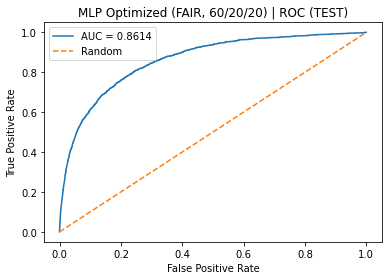

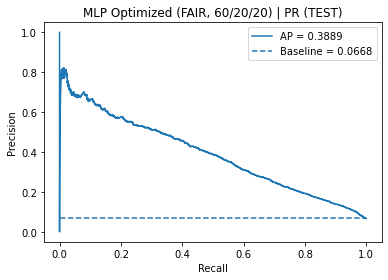

In [37]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

for col in ["Unnamed: 0", "ID", "Id", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])

assert TARGET in df.columns, f"Target '{TARGET}' not found."

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET])

X = X.apply(pd.to_numeric, errors="coerce")



X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Positive rate train={y_train.mean():.4f} | val={y_val.mean():.4f} | test={y_test.mean():.4f}")

numeric_cols = X_train.columns.tolist()




class QuantileClipper(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.01, high=0.99):
        self.low = low
        self.high = high

    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.lo_ = np.nanquantile(X, self.low, axis=0)
        self.hi_ = np.nanquantile(X, self.high, axis=0)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        return np.clip(X, self.lo_, self.hi_)

class SafeLog1p(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.can_log_ = np.nanmin(X, axis=0) >= 0
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X_out = X.copy()
        cols = np.where(self.can_log_)[0]
        if len(cols) > 0:
            X_out[:, cols] = np.log1p(np.maximum(X_out[:, cols], 0))
        return X_out



numeric_pipe_mlp = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("clip", QuantileClipper(low=0.01, high=0.99)),
    ("log1p", SafeLog1p()),
    ("scaler", StandardScaler()),
])

preprocess_mlp = ColumnTransformer(
    transformers=[("num", numeric_pipe_mlp, numeric_cols)],
    remainder="drop"
)



mlp = MLPClassifier(
    activation="relu",
    solver="adam",
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    max_iter=200,
    random_state=42
)

pipe_mlp = Pipeline(steps=[
    ("prep", preprocess_mlp),
    ("mlp", mlp)
])




param_dist_mlp = {
    "mlp__hidden_layer_sizes": [(128, 64), (256, 128), (128, 128), (256, 64)],
    "mlp__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [5e-4, 1e-3, 2e-3],
    "mlp__batch_size": [128, 256, 512],
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

search_mlp = RandomizedSearchCV(
    estimator=pipe_mlp,
    param_distributions=param_dist_mlp,
    n_iter=12,                        
    scoring="average_precision",      
    cv=cv,
    random_state=42,
    n_jobs=1,
    verbose=1
)

search_mlp.fit(X_train, y_train)
best_mlp = search_mlp.best_estimator_

print("\nBest CV PR-AUC:", search_mlp.best_score_)
print("Best params:", search_mlp.best_params_)



p_test = best_mlp.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, p_test)
ap_test  = average_precision_score(y_test, p_test)

print(f"\n[MLP Optimized (FAIR, 60/20/20)] TEST ROC-AUC: {auc_test:.4f}")
print(f"[MLP Optimized (FAIR, 60/20/20)] TEST PR-AUC : {ap_test:.4f}")


THRESHOLD = 0.5
y_pred = (p_test >= THRESHOLD).astype(int)

print(f"\n=== TEST evaluation @ threshold = {THRESHOLD:.2f} ===")
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))


# ROC & PR plots 

def plot_roc_pr_probs(p, y_true, title_prefix="MLP Optimized (FAIR)"):
    # ROC
    fpr, tpr, _ = roc_curve(y_true, p)
    auc = roc_auc_score(y_true, p)
    plt.figure(figsize=(5.5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], "--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title_prefix} | ROC (TEST)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_true, p)
    ap = average_precision_score(y_true, p)
    base = y_true.mean()
    plt.figure(figsize=(5.5, 4))
    plt.plot(rec, prec, label=f"AP = {ap:.4f}")
    plt.hlines(base, 0, 1, linestyles="--", label=f"Baseline = {base:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} | PR (TEST)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc_pr_probs(p_test, y_test, title_prefix="MLP Optimized (FAIR, 60/20/20)")



In [38]:
from sklearn.utils import resample
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def bootstrap_metrics(model, X_test, y_test, n_boot=100, title="Model"):
    """
    Compute bootstrapped estimates of ROC-AUC and PR-AUC.
    
    Parameters:
        model: trained sklearn model with predict_proba
        X_test, y_test: test data
        n_boot: number of bootstrap iterations
        title: string for print
    
    Returns:
        (mean_auc, std_auc), (mean_ap, std_ap)
    """
    auc_scores = []
    ap_scores = []
    
    for i in range(n_boot):
        X_res, y_res = resample(X_test, y_test, replace=True, random_state=None)
        p_res = model.predict_proba(X_res)[:, 1]
        auc_scores.append(roc_auc_score(y_res, p_res))
        ap_scores.append(average_precision_score(y_res, p_res))
    
    mean_auc, std_auc = np.mean(auc_scores), np.std(auc_scores)
    mean_ap, std_ap = np.mean(ap_scores), np.std(ap_scores)
    
    print(f"\n=== {title} | Bootstrapped evaluation ({n_boot} iterations) ===")
    print(f"ROC-AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"PR-AUC : {mean_ap:.4f} ± {std_ap:.4f}")
    
    return (mean_auc, std_auc), (mean_ap, std_ap)


mlp_optimized = best_mlp

# Bootstrap evaluation
auc_rf_boot, ap_rf_boot = bootstrap_metrics(rf_optimized, X_test, y_test, n_boot=100, title="RF Optimized")
auc_mlp_boot, ap_mlp_boot = bootstrap_metrics(mlp_optimized, X_test, y_test, n_boot=100, title="MLP Optimized")



=== RF Optimized | Bootstrapped evaluation (100 iterations) ===
ROC-AUC: 0.8637 ± 0.0041
PR-AUC : 0.3987 ± 0.0089

=== MLP Optimized | Bootstrapped evaluation (100 iterations) ===
ROC-AUC: 0.8613 ± 0.0039
PR-AUC : 0.3893 ± 0.0129


## 3 Interpretation of Results with SHAP

### Beeswarm + Bar for MLP

Using model: MLPClassifier
X_train_proc: (90000, 12) | X_test_proc: (30000, 12)


  0%|          | 0/300 [00:00<?, ?it/s]

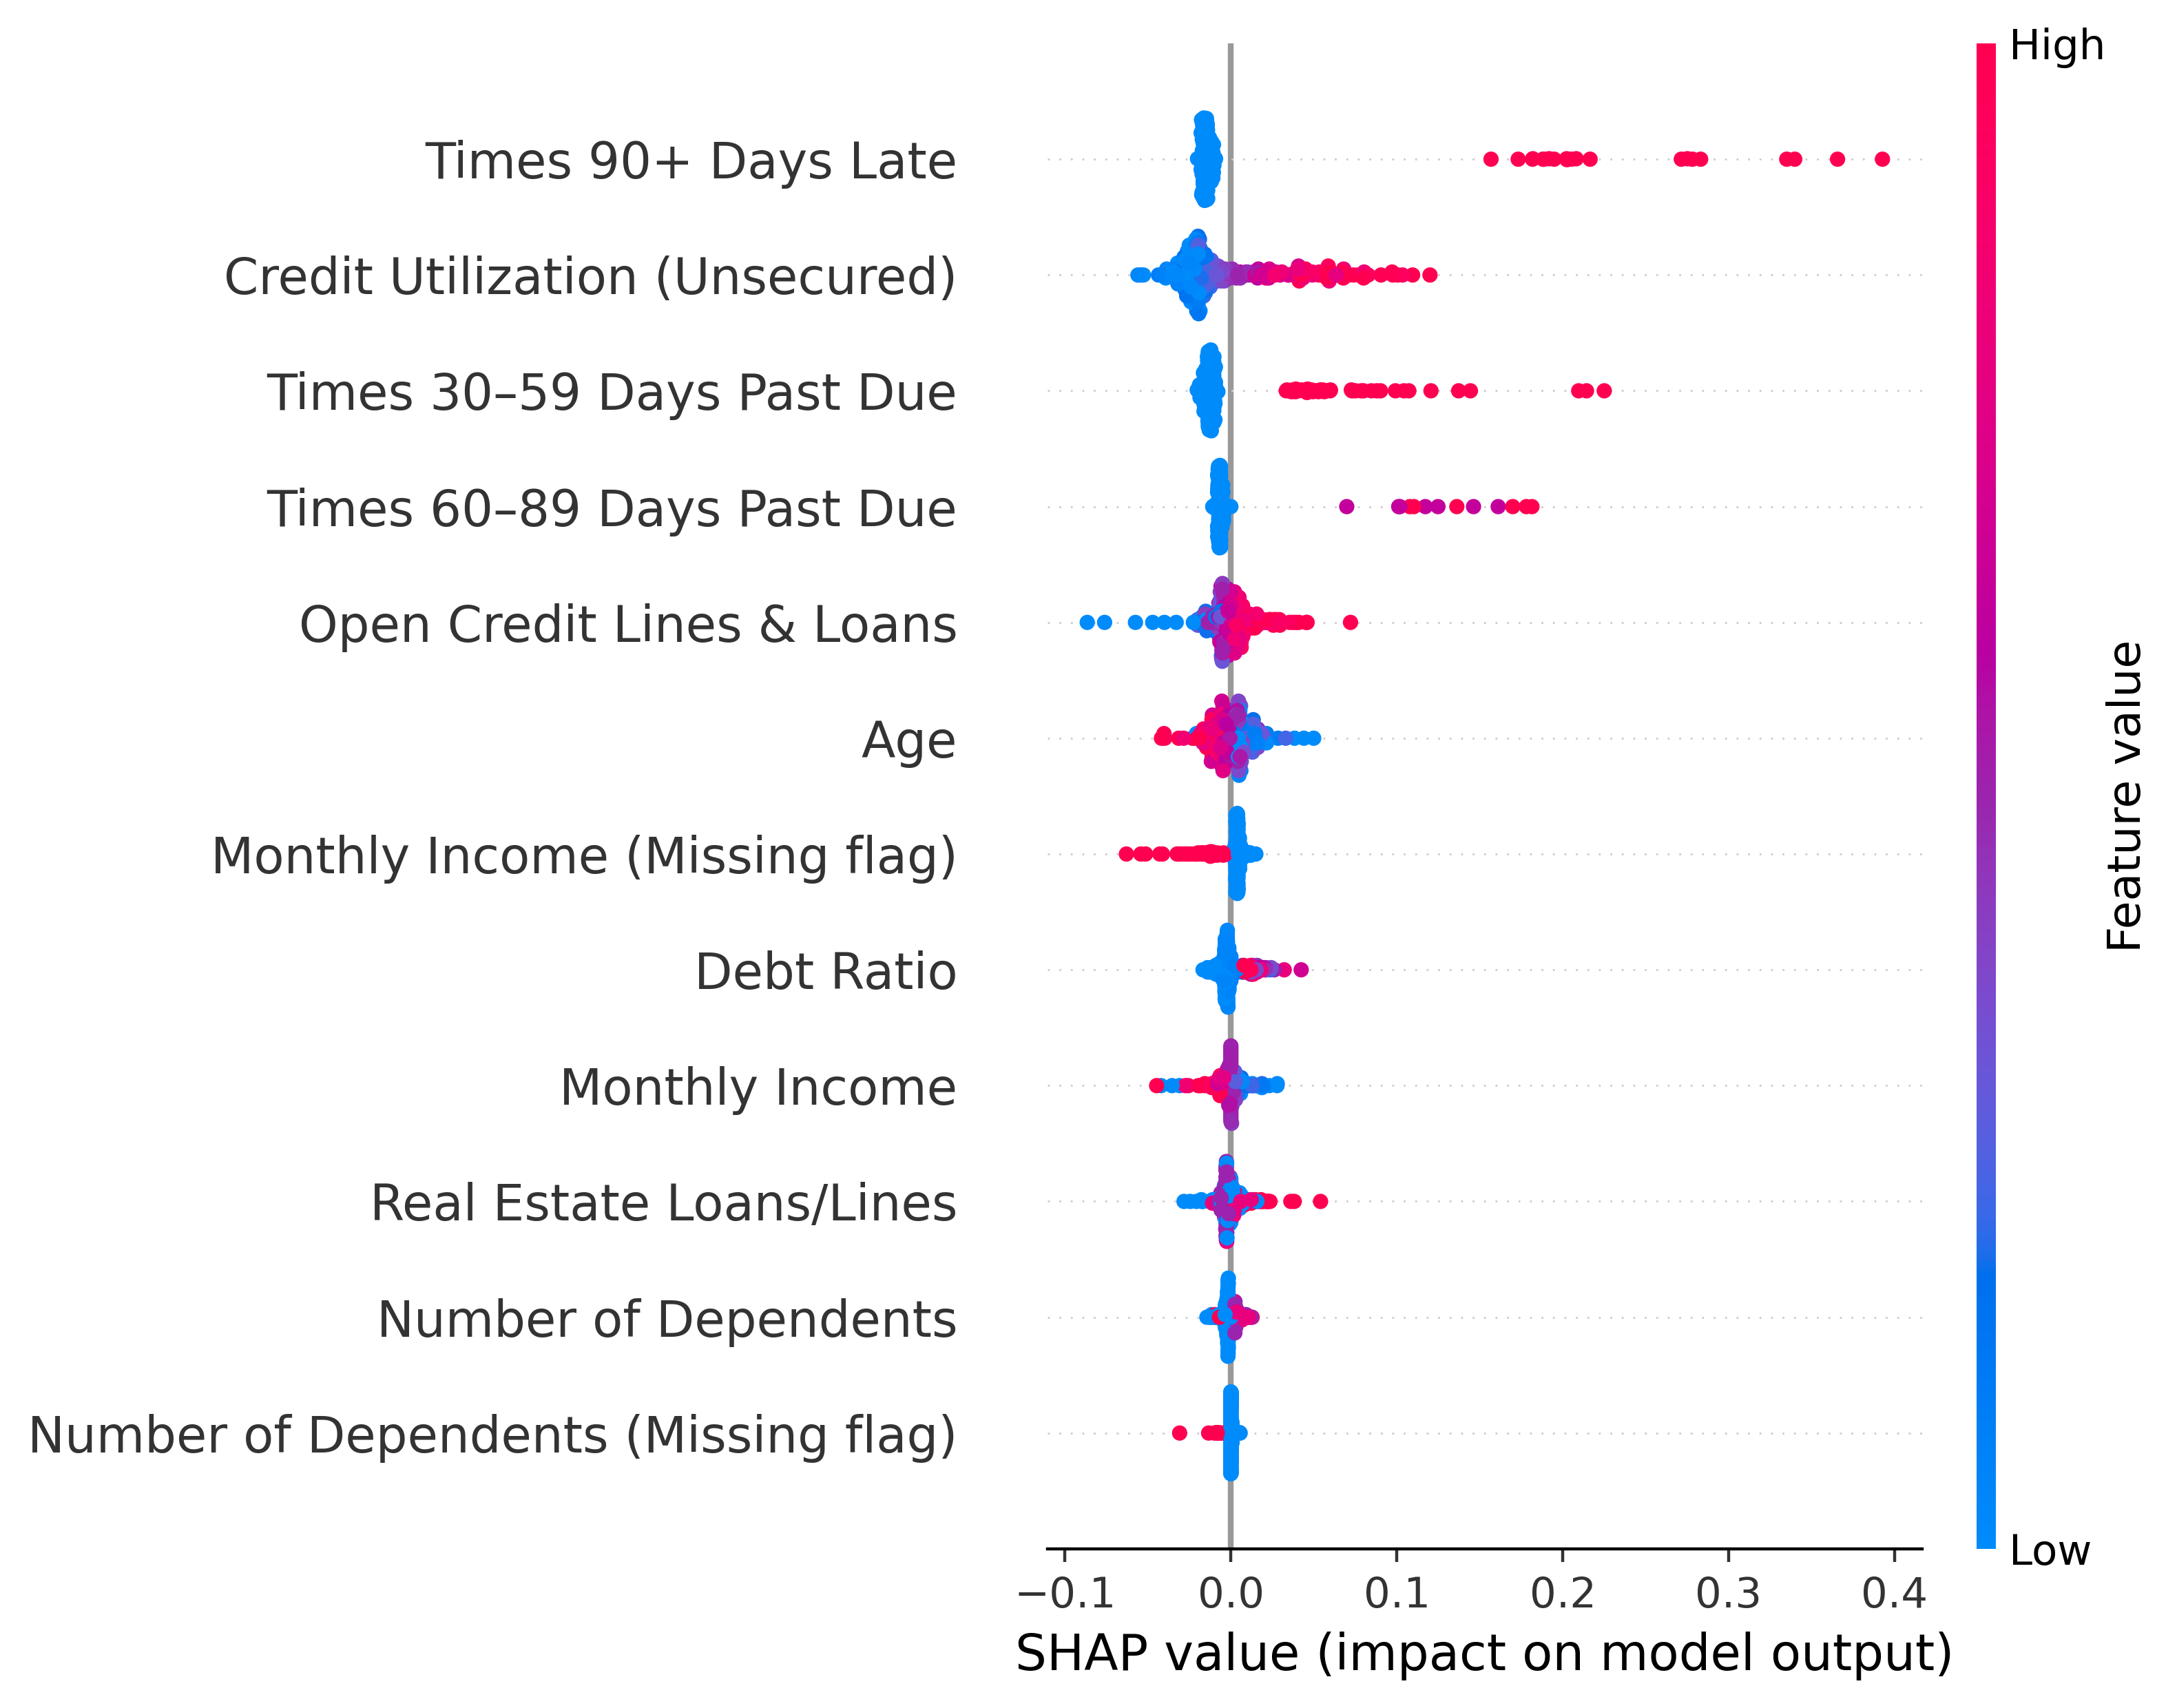

[SAVED] shap_figs/mlp_shap_beeswarm_top12.png


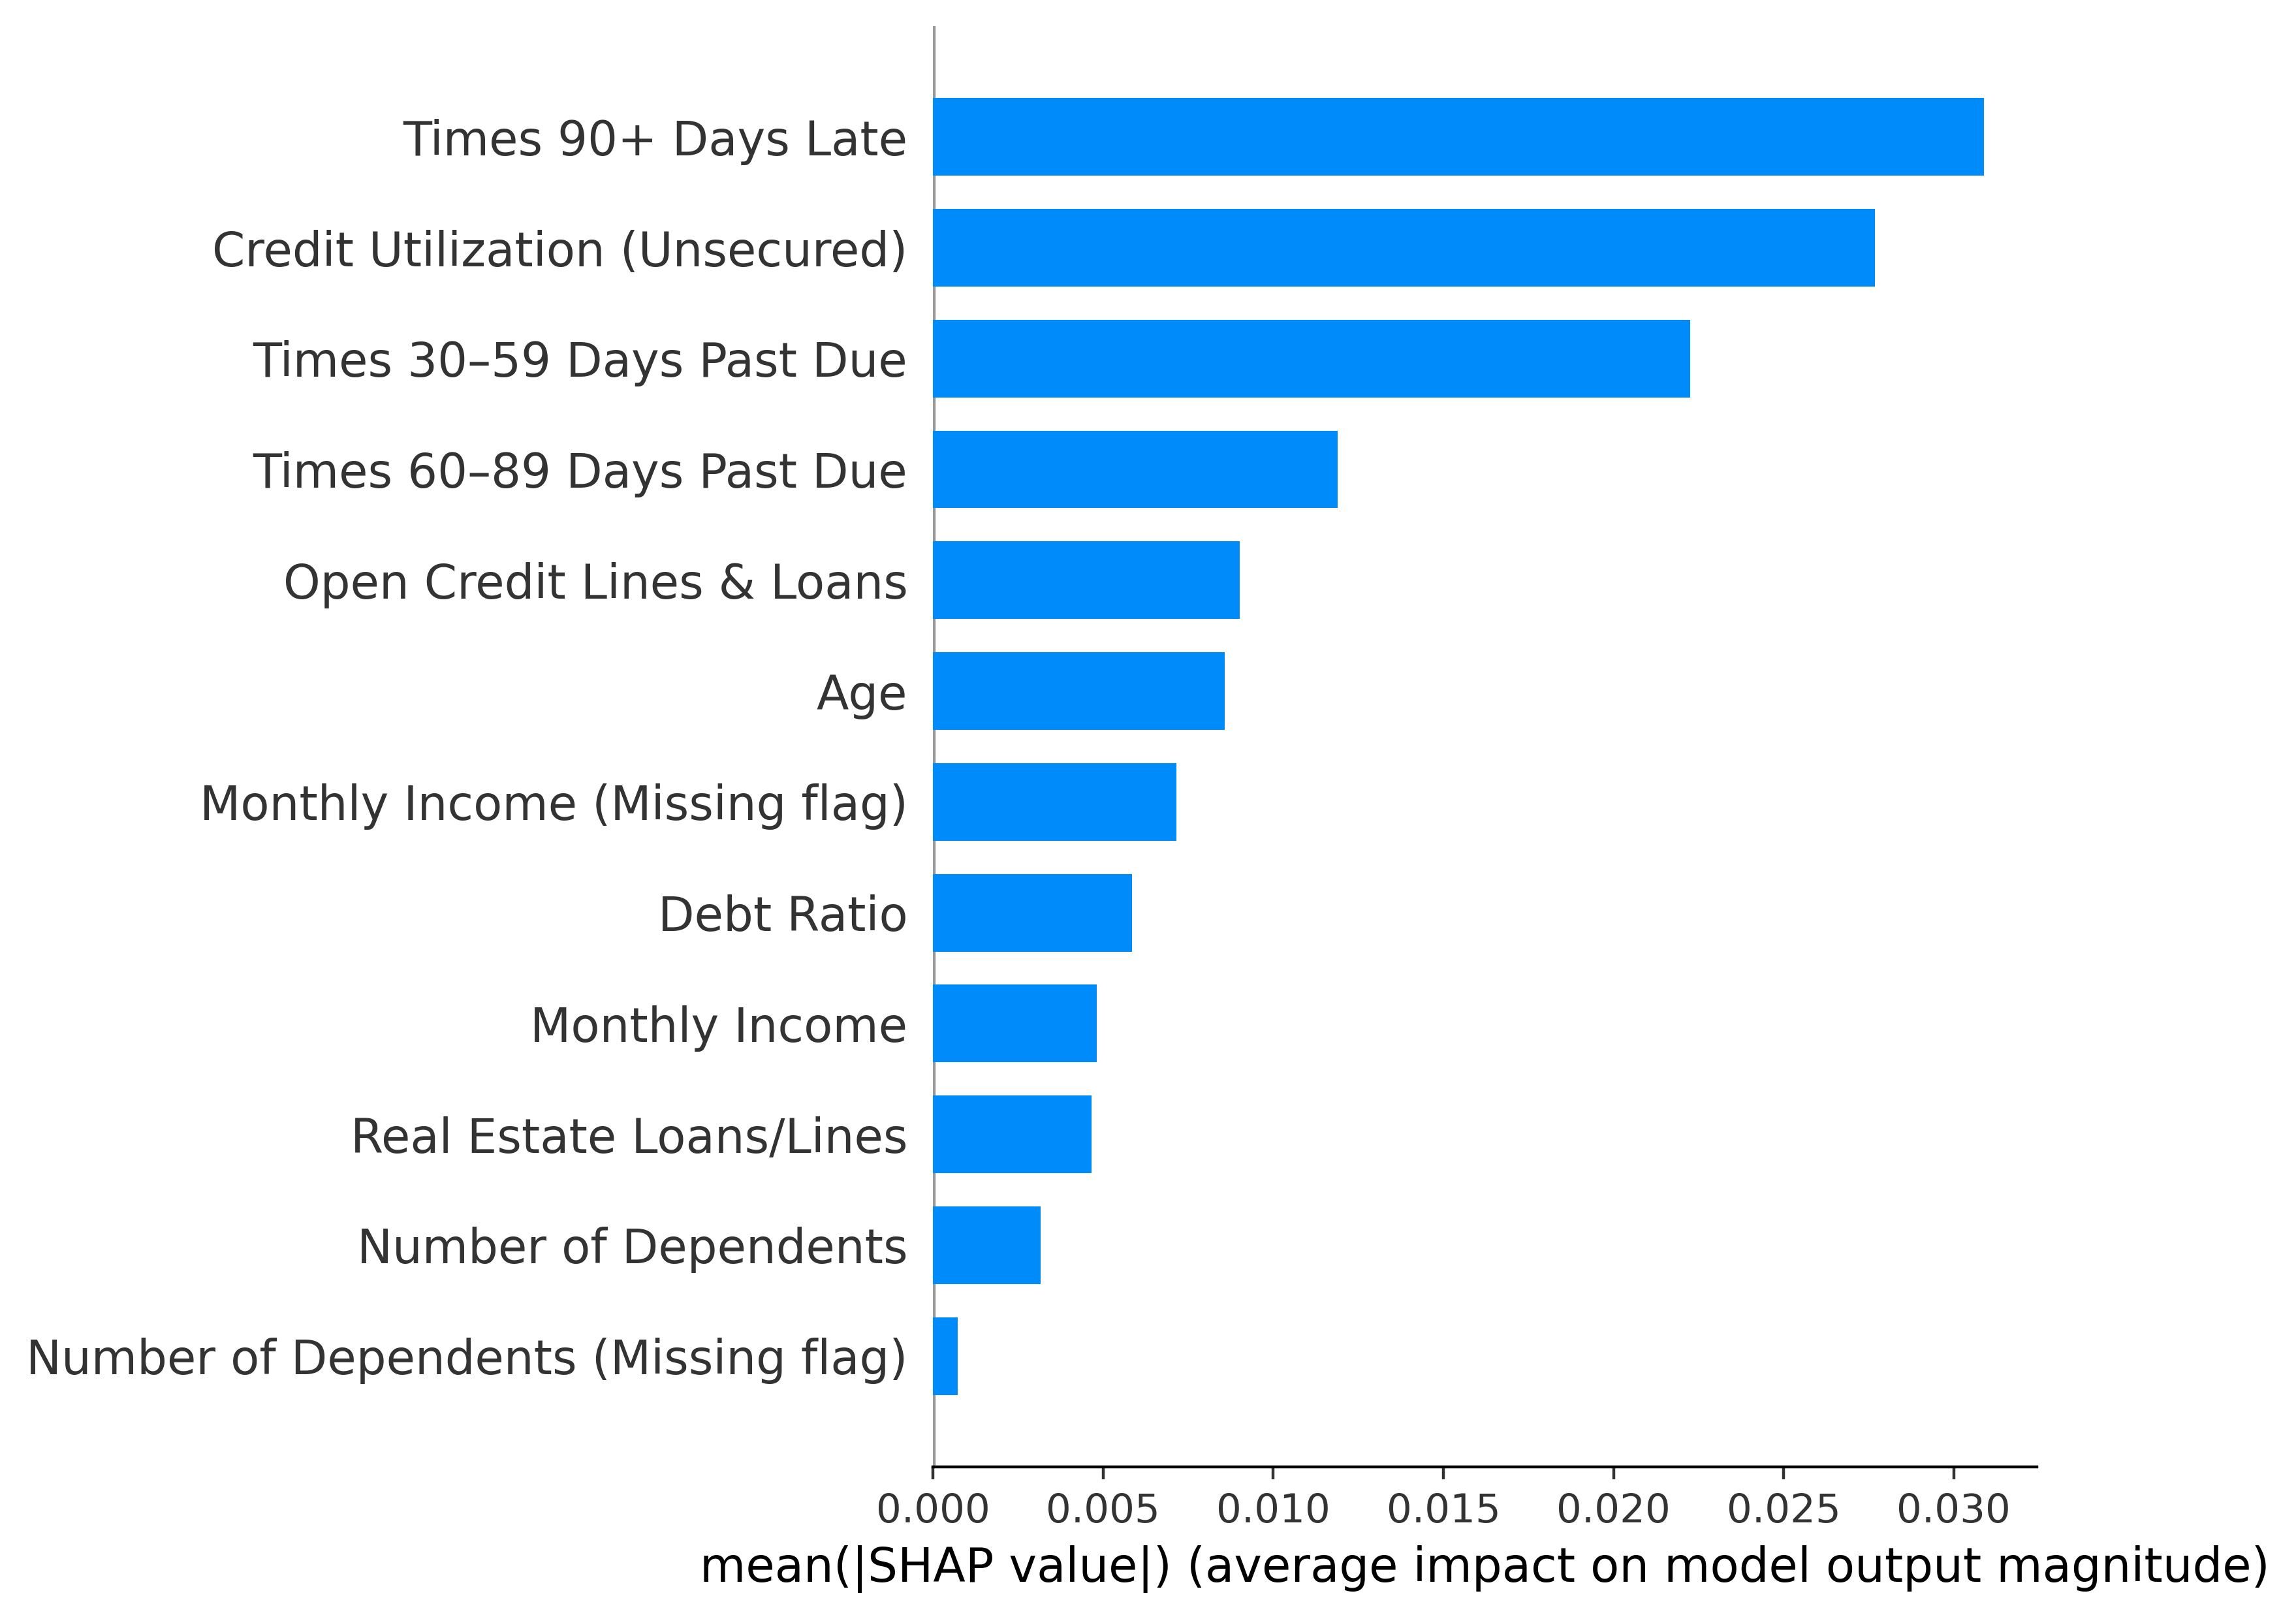

[SAVED] shap_figs/mlp_shap_bar_top12.png


In [39]:

# SHAP for MLP : Beeswarm + Bar 

import shap


if "best_mlp" not in globals():
    raise NameError("Không thấy best_mlp. Hãy chạy phần training/tuning MLP trước.")

model = best_mlp
prep = model.named_steps["prep"]
mlp  = model.named_steps["mlp"]

X_train_proc = prep.transform(X_train)
X_test_proc  = prep.transform(X_test)

print("Using model:", type(mlp).__name__)
print("X_train_proc:", X_train_proc.shape, "| X_test_proc:", X_test_proc.shape)


numeric_cols = list(X_train.columns)
feature_names = numeric_cols.copy()

try:
    num_pipe = prep.named_transformers_.get("num", None)
    imputer = None
    if num_pipe is not None and hasattr(num_pipe, "named_steps"):
        imputer = num_pipe.named_steps.get("imputer", None)

    if imputer is not None and getattr(imputer, "indicator_", None) is not None:
        miss_idx = list(imputer.indicator_.features_)
        miss_cols = [numeric_cols[i] for i in miss_idx]
        feature_names += [f"{c}_missing" for c in miss_cols]

    
    if len(feature_names) != X_train_proc.shape[1]:
        feature_names = [f"f{i}" for i in range(X_train_proc.shape[1])]
except Exception:
    feature_names = [f"f{i}" for i in range(X_train_proc.shape[1])]


pretty_map = {
    "RevolvingUtilizationOfUnsecuredLines": "Credit Utilization (Unsecured)",
    "DebtRatio": "Debt Ratio",
    "MonthlyIncome": "Monthly Income",
    "age": "Age",
    "NumberOfOpenCreditLinesAndLoans": "Open Credit Lines & Loans",
    "NumberRealEstateLoansOrLines": "Real Estate Loans/Lines",
    "NumberOfDependents": "Number of Dependents",
    "NumberOfTime30-59DaysPastDueNotWorse": "Times 30–59 Days Past Due",
    "NumberOfTime60-89DaysPastDueNotWorse": "Times 60–89 Days Past Due",
    "NumberOfTimes90DaysLate": "Times 90+ Days Late",
}

def prettify(name: str) -> str:
    if name.endswith("_missing"):
        base = name[:-len("_missing")]
        base_pretty = pretty_map.get(base, base)
        return f"{base_pretty} (Missing flag)"
    return pretty_map.get(name, name)

pretty_feature_names = [prettify(n) for n in feature_names]

# SHAP setup (KernelExplainer for MLP) 

BG_SIZE = 80        
EXPLAIN_SIZE = 300  
NSAMPLES = 300      

rng = np.random.default_rng(42)
bg_size = min(BG_SIZE, X_train_proc.shape[0])
explain_size = min(EXPLAIN_SIZE, X_test_proc.shape[0])


background = shap.kmeans(X_train_proc, bg_size)


ex_idx = rng.choice(X_test_proc.shape[0], size=explain_size, replace=False)
X_explain = X_test_proc[ex_idx]

def predict_proba_pos(X):
    return mlp.predict_proba(X)[:, 1]

explainer = shap.KernelExplainer(predict_proba_pos, background)
shap_values = explainer.shap_values(X_explain, nsamples=NSAMPLES)  # shape: (n, d)

shap_values = np.asarray(shap_values)


TOP_K = 12
mean_abs = np.mean(np.abs(shap_values), axis=0)
top_idx = np.argsort(mean_abs)[::-1][:TOP_K]

S_top = shap_values[:, top_idx]
X_top = X_explain[:, top_idx]
names_top = [pretty_feature_names[i] for i in top_idx]

# Plot 
OUT_DIR = "shap_figs"
os.makedirs(OUT_DIR, exist_ok=True)
DPI = 400

# Beeswarm
beeswarm_path = os.path.join(OUT_DIR, f"mlp_shap_beeswarm_top{TOP_K}.png")
plt.figure(figsize=(10, 6), dpi=DPI)
shap.summary_plot(S_top, X_top, feature_names=names_top, show=False, max_display=TOP_K)
plt.tight_layout()
plt.savefig(beeswarm_path, dpi=DPI, bbox_inches="tight")
plt.show()
print("[SAVED]", beeswarm_path)

# Bar plot
bar_path = os.path.join(OUT_DIR, f"mlp_shap_bar_top{TOP_K}.png")
plt.figure(figsize=(8.5, 5.5), dpi=DPI)
shap.summary_plot(S_top, X_top, feature_names=names_top, plot_type="bar", show=False, max_display=TOP_K)
plt.tight_layout()
plt.savefig(bar_path, dpi=DPI, bbox_inches="tight")
plt.show()
print("[SAVED]", bar_path)


### Beeswarm + Bar for Random Forest

Using model: RandomForestClassifier


PermutationExplainer explainer: 1201it [32:03,  1.61s/it]                          


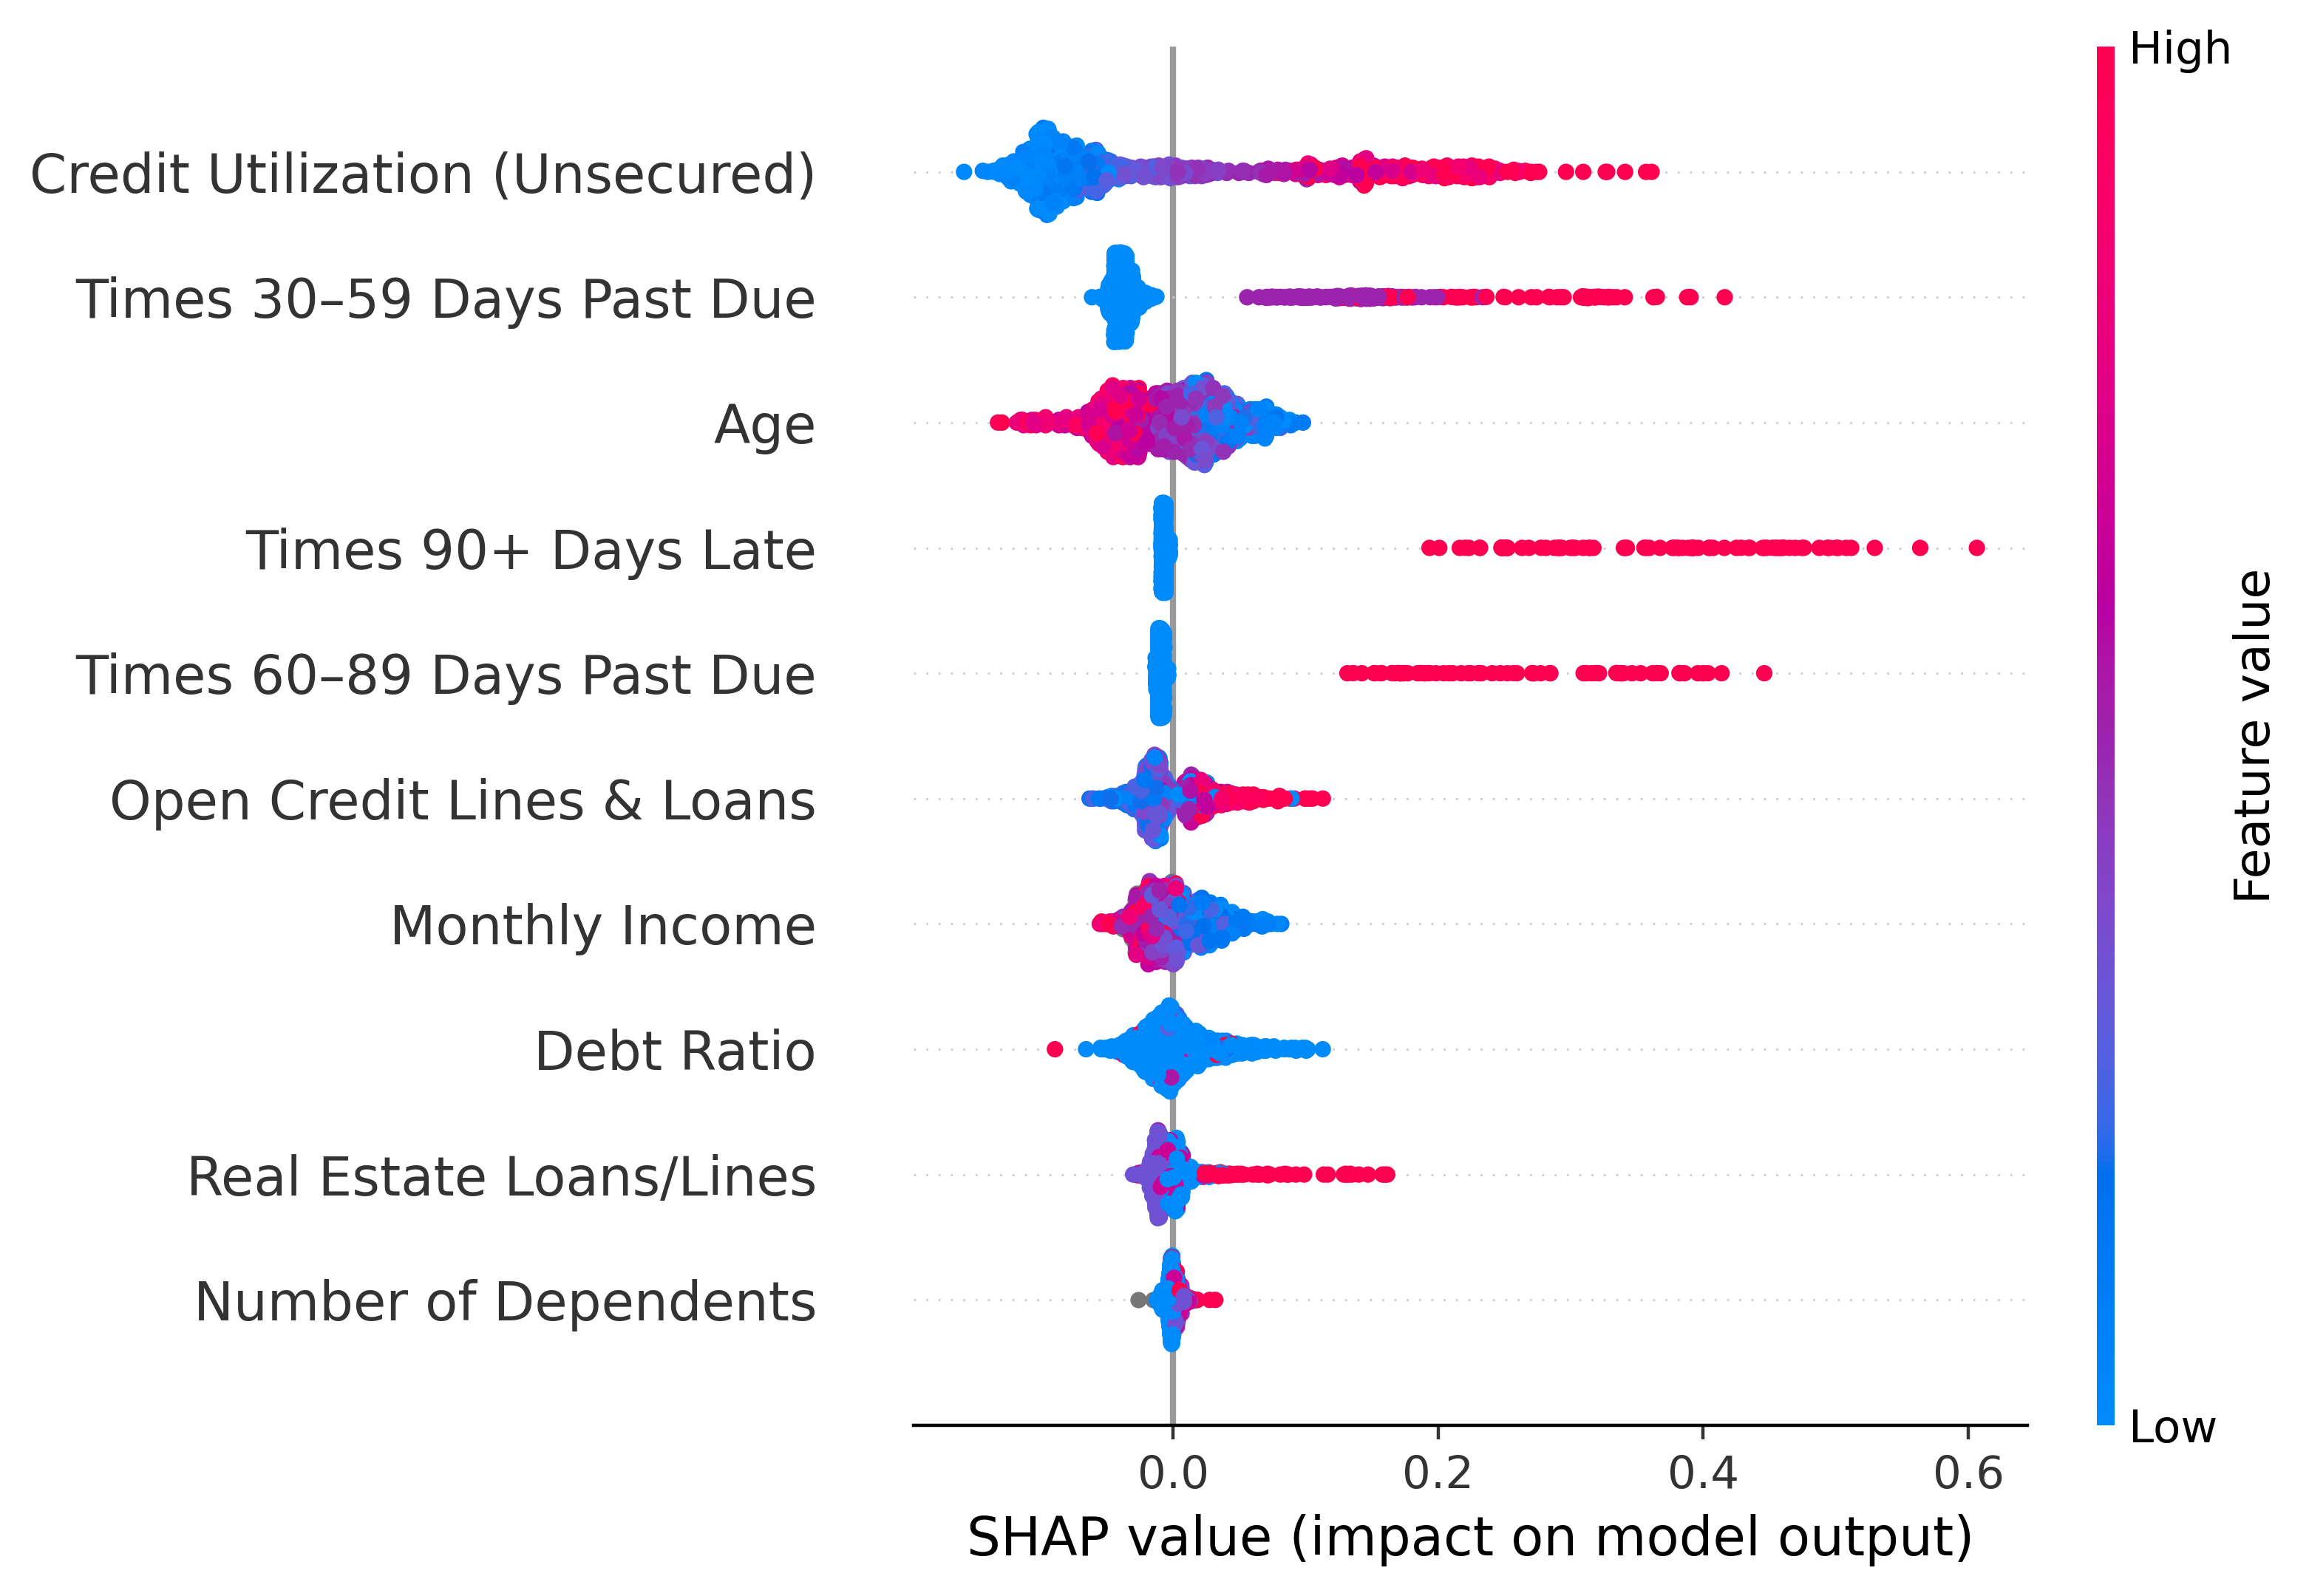

[SAVED] shap_figs/rf_shap_beeswarm_top12.png


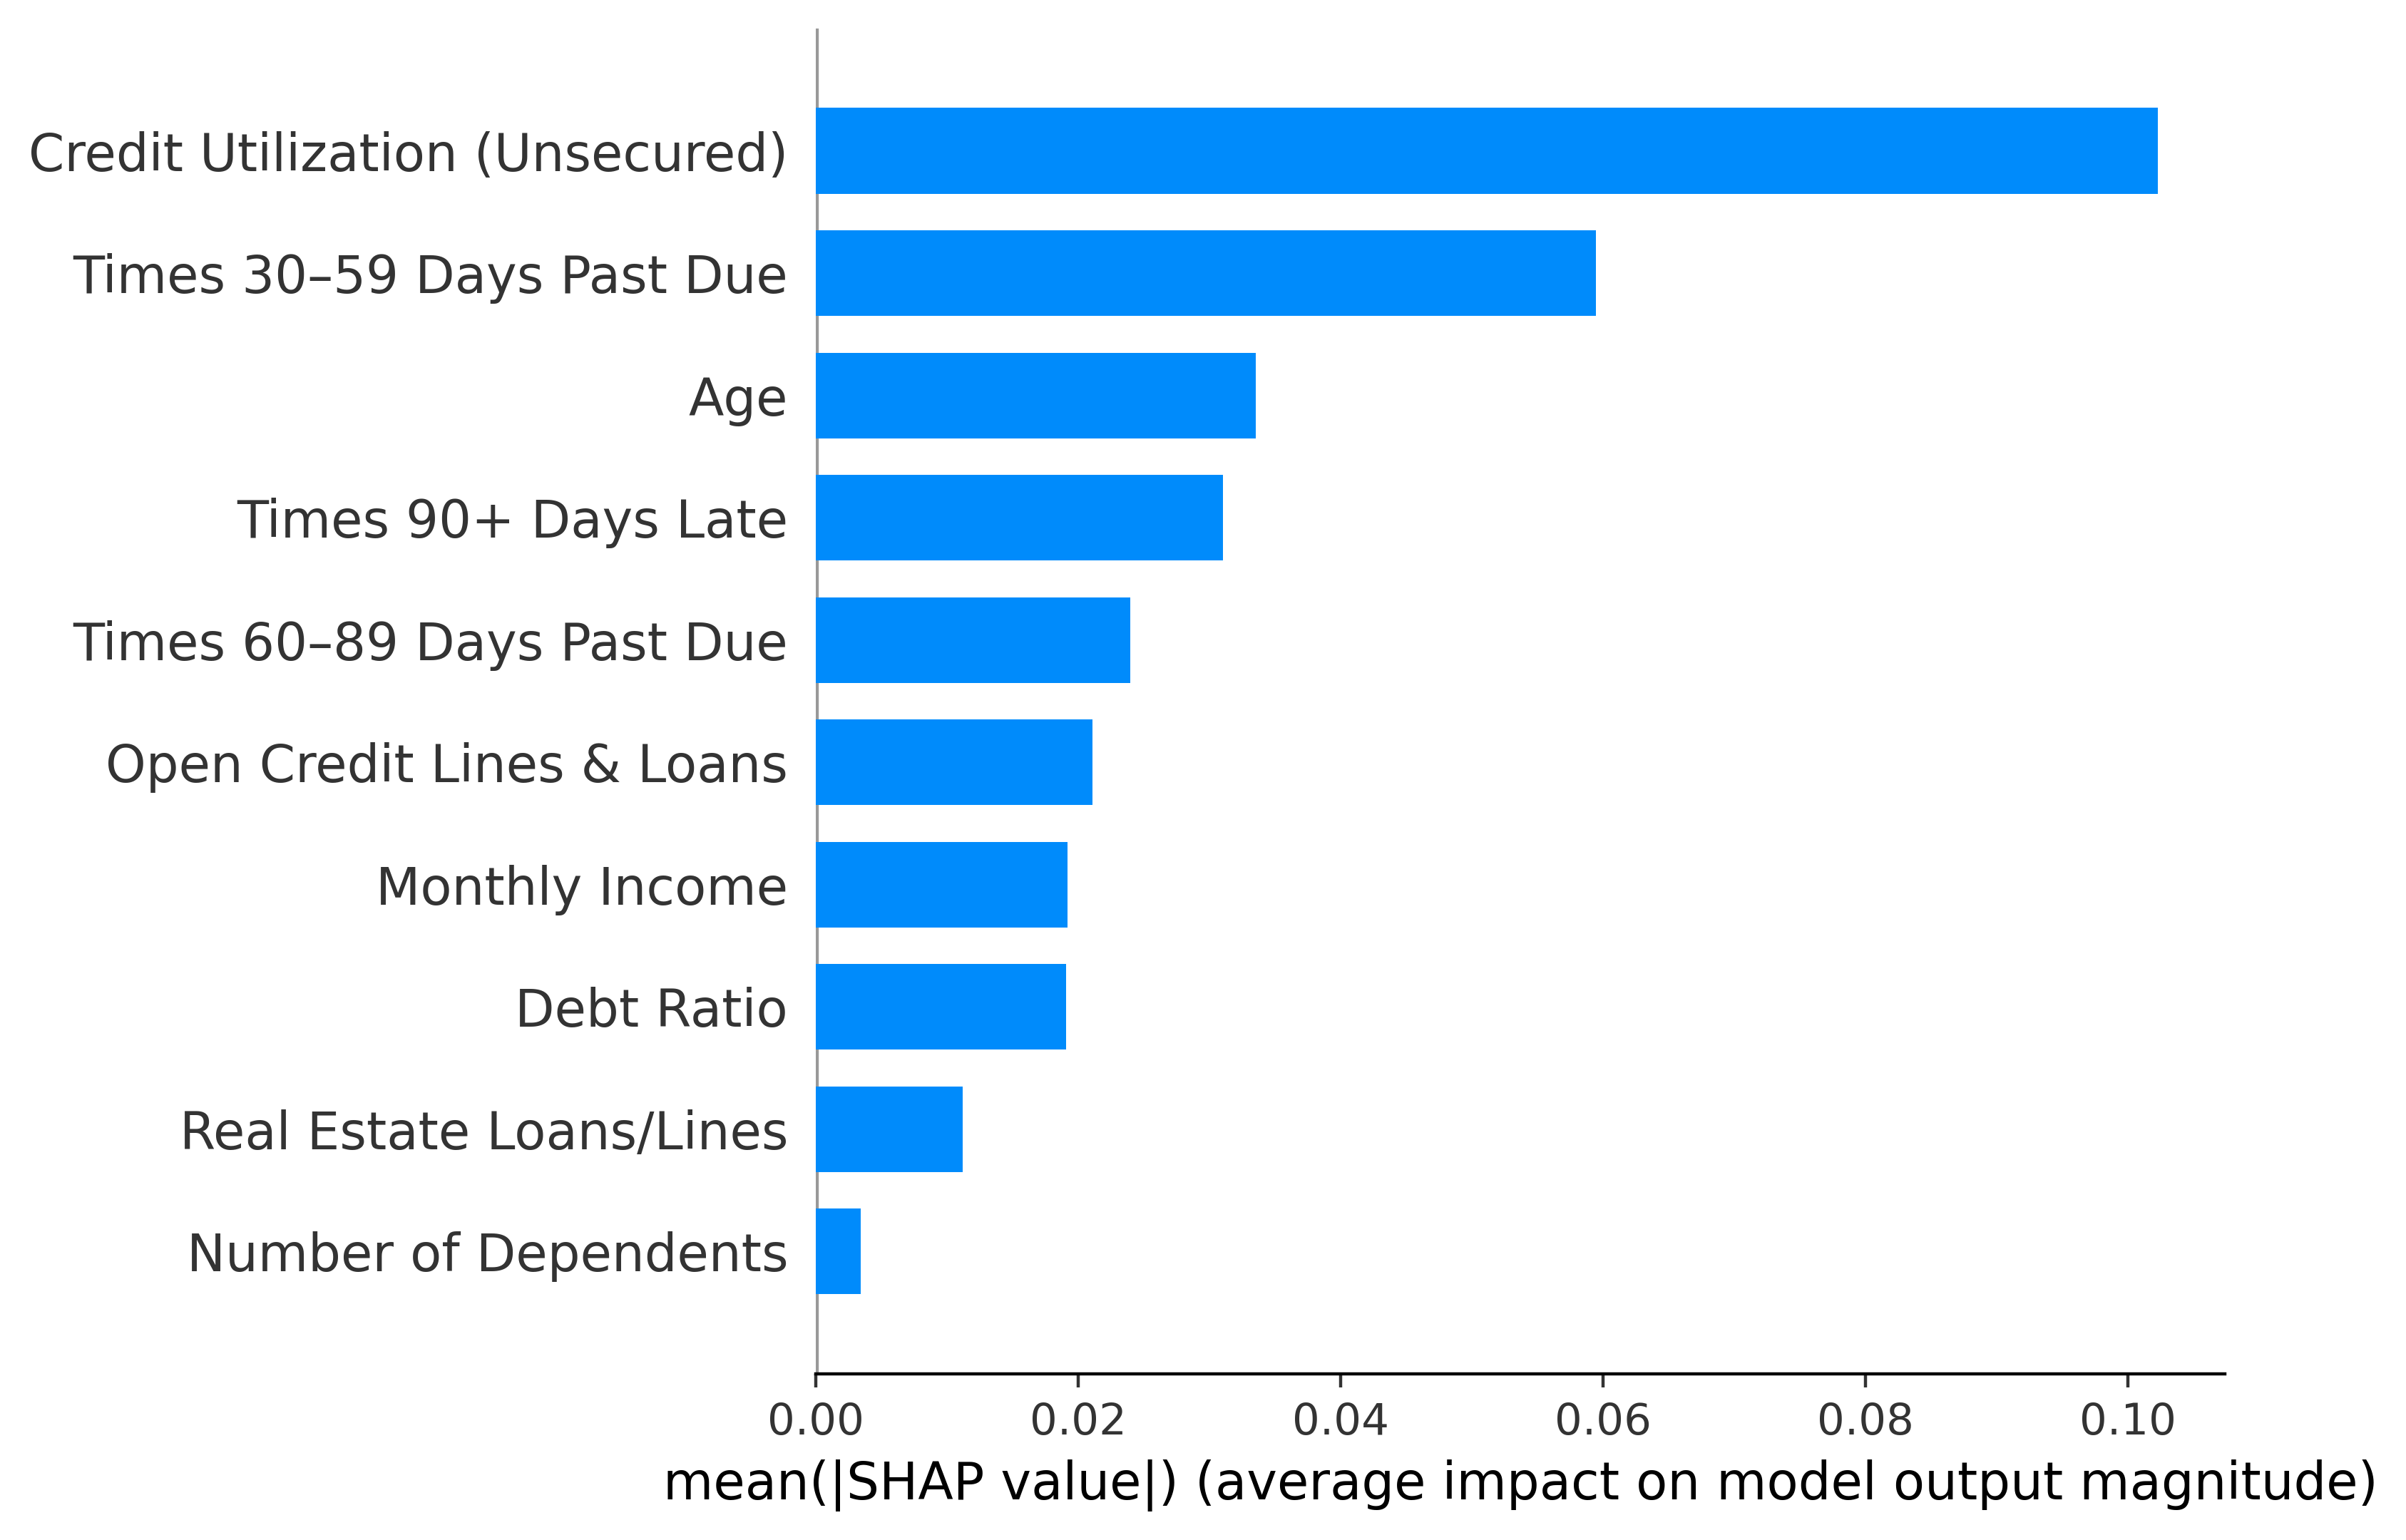

[SAVED] shap_figs/rf_shap_bar_top12.png


In [40]:
# SHAP for RF : Beeswarm + Bar 
if "rf_optimized" not in globals():
    raise NameError("Không thấy rf_optimized. Hãy chạy phần RF optimized trước.")

model = rf_optimized
prep = model.named_steps["prep"]
rf   = model.named_steps["rf"]

print("Using model:", type(rf).__name__)


numeric_cols = list(X_train.columns)
feature_names = numeric_cols.copy()

try:
 
    num_pipe = prep.named_transformers_.get("num", None)
    imputer = None
    if num_pipe is not None and hasattr(num_pipe, "named_steps"):
        imputer = num_pipe.named_steps.get("imputer", None)

    if imputer is not None and getattr(imputer, "indicator_", None) is not None:
        miss_idx = list(imputer.indicator_.features_)
        miss_cols = [numeric_cols[i] for i in miss_idx]
        feature_names += [f"{c}_missing" for c in miss_cols]

    X_train_proc = prep.transform(X_train)
    if len(feature_names) != X_train_proc.shape[1]:
        feature_names = [f"f{i}" for i in range(X_train_proc.shape[1])]
except Exception:
    X_train_proc = prep.transform(X_train)
    feature_names = [f"f{i}" for i in range(X_train_proc.shape[1])]


pretty_map = {
    "RevolvingUtilizationOfUnsecuredLines": "Credit Utilization (Unsecured)",
    "DebtRatio": "Debt Ratio",
    "MonthlyIncome": "Monthly Income",
    "age": "Age",
    "NumberOfOpenCreditLinesAndLoans": "Open Credit Lines & Loans",
    "NumberRealEstateLoansOrLines": "Real Estate Loans/Lines",
    "NumberOfDependents": "Number of Dependents",
    "NumberOfTime30-59DaysPastDueNotWorse": "Times 30–59 Days Past Due",
    "NumberOfTime60-89DaysPastDueNotWorse": "Times 60–89 Days Past Due",
    "NumberOfTimes90DaysLate": "Times 90+ Days Late",
}

def prettify(name: str) -> str:
    if name.endswith("_missing"):
        base = name[:-len("_missing")]
        base_pretty = pretty_map.get(base, base)
        return f"{base_pretty} (Missing flag)"
    return pretty_map.get(name, name)

pretty_feature_names = [prettify(n) for n in feature_names]


BG_SIZE = 200        
EXPLAIN_SIZE = 1200  
TOP_K = 12

rng = np.random.default_rng(42)

bg_size = min(BG_SIZE, len(X_train))
explain_size = min(EXPLAIN_SIZE, len(X_test))

bg_idx = rng.choice(len(X_train), size=bg_size, replace=False)
ex_idx = rng.choice(len(X_test), size=explain_size, replace=False)

X_bg = X_train.iloc[bg_idx]
X_explain_df = X_test.iloc[ex_idx]

# SHAP TreeExplainer 

masker = shap.maskers.Independent(X_bg)
explainer = shap.Explainer(model.predict_proba, masker, algorithm="permutation")

sv = explainer(X_explain_df)    
sv1 = sv[..., 1]                

S = np.asarray(sv1.values)     

#  Top-K selection 
mean_abs = np.mean(np.abs(S), axis=0)
top_idx = np.argsort(mean_abs)[::-1][:TOP_K]

S_top = S[:, top_idx]
X_top = X_explain_df.iloc[:, top_idx]  
names_top = [pretty_feature_names[i] for i in top_idx]

# Plot 
OUT_DIR = "shap_figs"
os.makedirs(OUT_DIR, exist_ok=True)
DPI = 400

# Beeswarm
beeswarm_path = os.path.join(OUT_DIR, f"rf_shap_beeswarm_top{TOP_K}.png")
plt.figure(figsize=(10, 6), dpi=DPI)
shap.summary_plot(S_top, X_top, feature_names=names_top, show=False, max_display=TOP_K)
plt.tight_layout()
plt.savefig(beeswarm_path, dpi=DPI, bbox_inches="tight")
plt.show()
print("[SAVED]", beeswarm_path)

# Bar plot
bar_path = os.path.join(OUT_DIR, f"rf_shap_bar_top{TOP_K}.png")
plt.figure(figsize=(8.5, 5.5), dpi=DPI)
shap.summary_plot(S_top, X_top, feature_names=names_top, plot_type="bar", show=False, max_display=TOP_K)
plt.tight_layout()
plt.savefig(bar_path, dpi=DPI, bbox_inches="tight")
plt.show()
print("[SAVED]", bar_path)


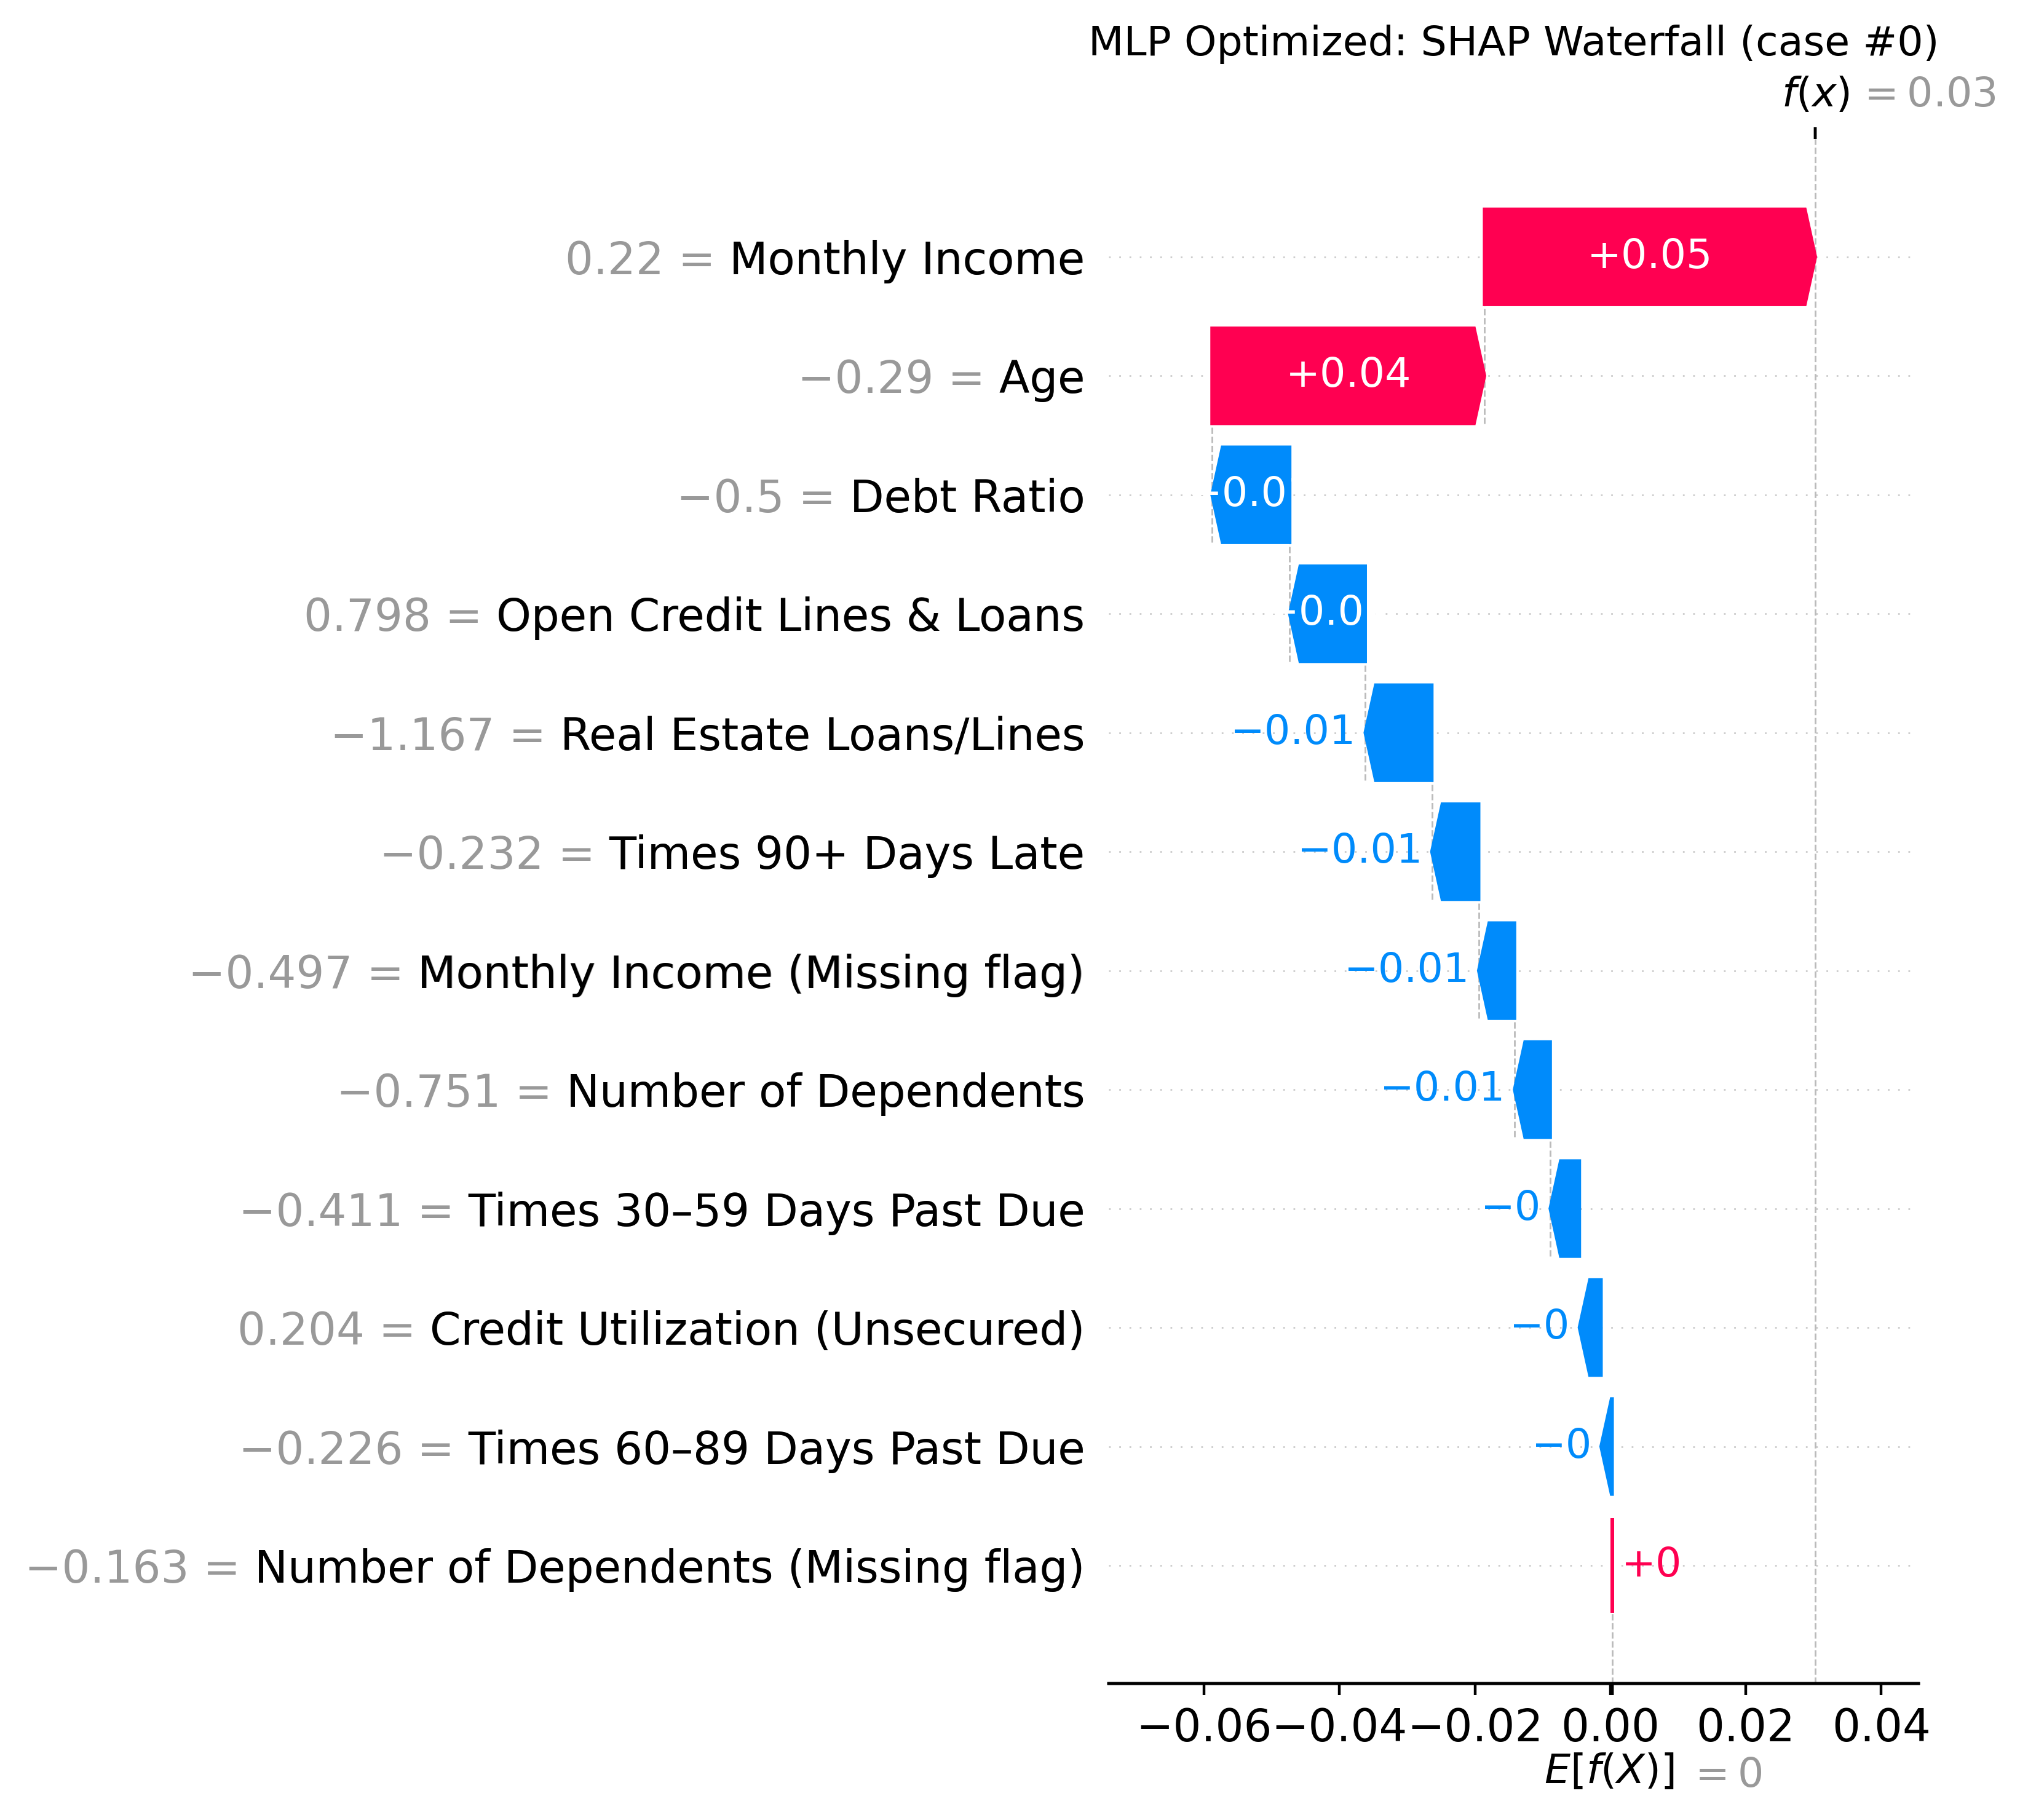